<a href="https://colab.research.google.com/github/taba4ek555/Diplom/blob/main/Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Добавляем гугл диск в гугл колаб с готовым датасетом
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Распаковываем архив с датасетом
!unzip /content/drive/MyDrive/LFW-FER.zip -d ./


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./LFW-FER/train/neutral/Nanni_Moretti_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Nanni_Moretti_0002.jpg  
  inflating: ./LFW-FER/train/neutral/Hushiar_Zebari_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Hushiar_Zebari_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Allen_Rock_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Allen_Rock_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Keith_Bogans_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Keith_Bogans_0002.jpg  
  inflating: ./LFW-FER/train/neutral/John_Kerry_0017.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._John_Kerry_0017.jpg  
  inflating: ./LFW-FER/train/neutral/Maria_Soledad_Alvear_Valenzuela_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Maria_Soledad_Alvear_Valenzuela_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Eric_Rosser_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/

In [ ]:
#Импортирование библиотек
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import metrics
import cv2
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
#Создаём словари для кодирования эмоций и списки для хранения данных
numbers_names = {0: 'negative', 1: 'neutral', 2: 'positive'}
names_numbers = {'negative': 0, 'neutral': 1, 'positive': 2}
train_images = []
train_labels = []
test_images = []
test_labels = []

Загрузка изображений


In [ ]:
folders = [folder for folder in os.listdir('./LFW-FER/train')if folder[0] != '.']
for i in range(len(folders)):
    folder = folders[i]
    for image_path in os.listdir(f'./LFW-FER/train/{folder}'):
        image = Image.open(f'./LFW-FER/train/{folder}/{image_path}')
        train_images.append(np.array(image))
        train_labels.append(names_numbers[folder])
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
folders = [folder for folder in os.listdir('./LFW-FER/eval')if folder[0] != '.']
for i in range(len(folders)):
    folder = folders[i]
    for image_path in os.listdir(f'./LFW-FER/eval/{folder}'):
        image = Image.open(f'./LFW-FER/eval/{folder}/{image_path}')
        test_images.append(np.array(image))
        test_labels.append(names_numbers[folder])
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
len(train_images), len(test_images)

(9330, 1157)

Пример изображений


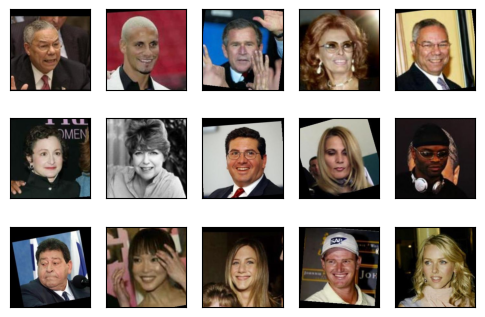

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(6, 4))
for i in range(15):
    ax = axs[i // 5, i % 5]
    ax.imshow(train_images[random.randint(0, len(train_images))])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1, 2]), array([ 768, 3359, 5203]))

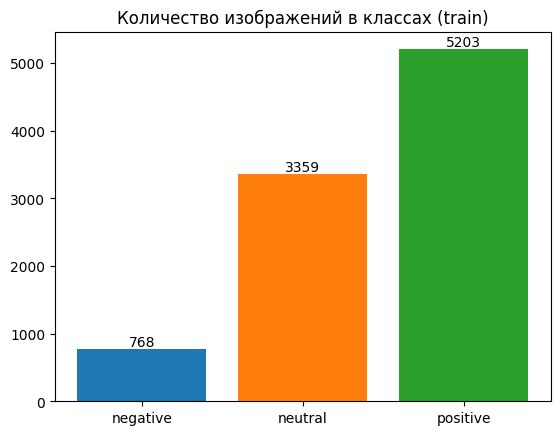

In [ ]:
for idx, label in enumerate(unique):
    bar = plt.bar(numbers_names[label], counts[idx], label=counts[idx])
    plt.bar_label(bar)
plt.title('Количество изображений в классах (train)')
plt.show()

In [ ]:
unique, counts = np.unique(test_labels, return_counts=True)
unique, counts

(array([0, 1, 2]), array([ 95, 417, 645]))

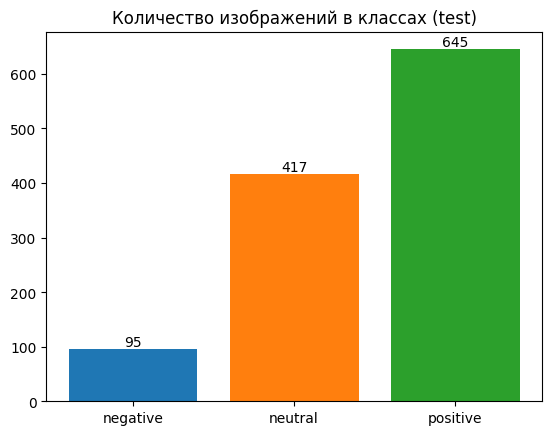

In [ ]:
for idx, label in enumerate(unique):
    bar = plt.bar(numbers_names[label], counts[idx], label=counts[idx])
    plt.bar_label(bar)
plt.title('Количество изображений в классах (test)')
plt.show()

Так как в наборе существует дисбаланс классов, необходимо использовать веса, чтобы модель больше уделяла внимания тем классам, в которых мало объектов

In [ ]:
#Используем веса для классов в котором мало объектов
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(train_labels),
                                    y=train_labels)
class_weight = dict(enumerate(class_weight))
class_weight

{0: 4.049479166666667, 1: 0.9258707948794284, 2: 0.597732077647511}

МОДЕЛИРОВАНИЕ


Для первой модели будем использовать 3 сверточных слоя с увеличением количества фильтров в два раза на каждом слое, также между ними будем использовать batch normalization слои для более быстрого обучения и слои max pooling для уменьшения изображения


In [ ]:
model1 = keras.Sequential([
    keras.Input(train_images[0].shape),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])

Воспользуемся чекпоинт коллбэком, чтобы во время обучения сохранить модель с наименьшей ошибкой


In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './model1.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

В качестве оптимизатора будет использоваться Nadam

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])